In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from sympy import *

In [3]:
%load_ext autoreload
%autoreload 2
from relation import Distribution
from relation import Analysis

In [4]:
a = Analysis(50,'140','')

In [5]:
a.distribution.z

0.032637493

In [6]:
df = a.get_dataframe()

Text(0, 0.5, '$V_{z}$')

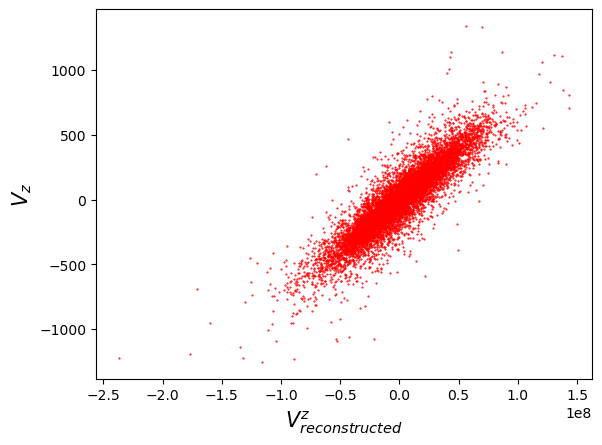

In [7]:
plt.plot(df['Vz'],df['Vlos'],'r.',markersize=1)
plt.xlabel("$V^z_{reconstructed}$",fontsize=15)
plt.ylabel("$V_{z}$",fontsize=15)

In [8]:
np.corrcoef(df['Vz'],df['Vlos'])

array([[1.        , 0.90020922],
       [0.90020922, 1.        ]])

In [18]:
df

,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m500c[Msol/h],r500c[kpc/h],gas_frac,...,Vx,Vy,Vz,Vnet,vnet,Mstar,Mgas,Vlos,Y,M
0,0,208707.3800,203892.310,349705.0300,9714,6893,6,1.032820e+15,1239.470,0.122792,...,-2.537422e+07,-7.024034e+07,-443.393201,868.535085,282.734776,31.374200,1.811743e+14,-197.449,-11.521859,34.927744
1,1,314110.3100,24347.102,278058.4400,14620,15250,15,6.263050e+14,1049.090,0.116260,...,-5.578088e+07,2.602357e+07,-579.403349,845.329228,420.658838,30.893906,1.040203e+14,-256.902,-11.813518,34.427534
2,2,83776.2580,206510.050,144915.3100,3899,6771,4,7.927850e+14,1134.840,0.121408,...,-2.686117e+07,6.671624e+06,-49.793668,281.216495,210.422788,30.867264,1.375006e+14,-124.361,-12.259982,34.663248
3,3,183729.8300,193320.660,332756.0000,8551,7385,6,1.800290e+14,692.373,0.112743,...,8.108886e+07,4.130841e+07,80.603279,913.605896,1151.476184,29.542894,2.899573e+13,-434.947,-12.564427,33.180814
4,4,327315.4100,233257.000,209403.9500,15235,5526,7,6.558460e+14,1065.330,0.114432,...,3.844139e+07,5.183772e+07,-422.868392,771.561215,283.361004,30.897589,1.072140e+14,-111.475,-12.618172,34.473622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10488,15109,245532.7300,47902.445,327681.7500,11428,14154,14,7.078800e+12,235.432,0.071753,...,-8.979108e+06,-4.393240e+07,-189.210063,486.691343,423.034247,26.349856,7.256053e+11,-76.752,-17.986969,29.944800
10489,15124,93769.9140,81091.062,252886.4400,4364,12609,13,7.258270e+12,237.408,0.064047,...,1.499214e+07,3.297285e+07,-269.601437,451.533229,313.121018,26.515192,6.641037e+11,-216.831,-17.036998,29.969838
10490,15297,165208.6700,66284.719,57955.0550,7689,13298,13,7.186580e+12,236.624,0.051829,...,-1.643864e+07,1.094693e+07,229.401304,302.706742,208.150635,26.598902,5.321057e+11,147.111,-17.646525,29.959911
10491,15831,65617.1250,153918.000,3217.6663,3054,9219,8,7.527190e+12,240.301,0.078434,...,-3.017290e+07,1.801027e+07,480.645599,595.396973,646.156878,26.259510,8.434141e+11,557.996,-15.852745,30.006218


In [17]:
#df.Vnet = df.Vnet.apply(lambda x: x/1e5)
#df.Vz = df.Vz.apply(lambda x: x/1e5)
#df.Mstar = df.Mstar.apply(lambda x: np.log(x))

In [74]:
df["Vz2"] = df["Vz"]**2
df["Mstar2"] = df["Mstar"]**2
df["Vz*Mstar"] = df["Vz"]*df["Mstar"]

In [37]:
train_df, test_df = train_test_split(df, train_size=0.5, random_state=42)

In [83]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

class ScatterReductionProject:
    def __init__(self, data_df):
        self.data_df = data_df
        self.X = data_df[['Vz', 'Vnet','Mstar', 'M']]
        self.y = data_df['Y']
        self.best_hyperparameters = {}
        self.models = {}

    def split_data(self, test_size=0.2, tune_size=0.2, random_state=42):
        X_train, X_temp, y_train, y_temp = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
        X_test, X_tune, y_test, y_tune = train_test_split(X_temp, y_temp, test_size=tune_size, random_state=random_state)
        
        self.X_train, self.X_test, self.X_tune = X_train, X_test, X_tune
        self.y_train, self.y_test, self.y_tune = y_train, y_test, y_tune

    def fit_power_law(self, X, y):
        log_X = np.log10(X)
        log_y = np.log10(y)
        fit = np.polyfit(log_X, log_y, 1)
        return fit

    def get_fit(self, which, powerlaw=False):
        if which == 'train':
            X, y = self.X_train, self.y_train
        elif which == 'test':
            X, y = self.X_test, self.y_test
        elif which == 'tune':
            X, y = self.X_tune, self.y_tune
        else:
            raise ValueError("Invalid value for 'which'. Use 'train', 'test', or 'tune'.")

        if powerlaw:
            fit = self.fit_power_law(X, y)
        else:
            fit = np.polyfit(np.log10(X), np.log10(y), 1)
        return fit

    def find_best_hyperparameters(self, param_grid, cv=5):
        rf_regressor = RandomForestRegressor()
        grid_search = GridSearchCV(rf_regressor, param_grid, cv=cv, n_jobs=-1, verbose=3)
        grid_search.fit(self.X_tune, self.y_tune)
        self.best_hyperparameters = grid_search.best_params_

    def fit_with_hyperparameters(self, features, target):
        rf_regressor = RandomForestRegressor(**self.best_hyperparameters)
        X_train = self.X_train[features]
        X_test = self.X_test[features]
        rf_regressor.fit(X_train, self.y_train)
        features_key = "_".join(features)
        self.models[features_key] = rf_regressor

    def calculate_scatter(self, features):
        features_key = "_".join(features)  # Convert list of features to a string key
        rf_regressor = self.models[features_key]
        X_train = self.X_train[features]
        X_test = self.X_test[features]
        # Convert features to a 2D array
        X_train = X_train.values.reshape(-1, len(features))
        X_test = X_test.values.reshape(-1, len(features))
        y_train_pred = rf_regressor.predict(X_train)
        y_test_pred = rf_regressor.predict(X_test)
        train_scatter = np.sqrt(mean_squared_error(self.y_train, y_train_pred))
        test_scatter = np.sqrt(mean_squared_error(self.y_test, y_test_pred))
        return train_scatter, test_scatter

    def plot_scatter_statistics(self):
        import matplotlib.pyplot as plt

        train_scatters = []
        test_scatters = []
        feature_sets = list(self.models.keys())
        feature_sets = [feature_set.split("_") for feature_set in feature_sets]

        for features in feature_sets:
            train_scatter, test_scatter = self.calculate_scatter(features)
            train_scatters.append(train_scatter)
            test_scatters.append(test_scatter)
        
        train_percent_change = [100 * (sc - train_scatters[0]) / train_scatters[0] for sc in train_scatters]
        test_percent_change = [100 * (sc - test_scatters[0]) / test_scatters[0] for sc in test_scatters]


        plt.figure(figsize=(10, 6))
        plt.bar(np.arange(len(feature_sets)), train_scatters, width=0.4, align='center', label='Train Scatter')
        plt.bar(np.arange(len(feature_sets)) + 0.4, test_scatters, width=0.4, align='center', label='Test Scatter')
        plt.xticks(np.arange(len(feature_sets)), feature_sets, rotation=45)
        plt.xlabel('Feature Set')
        plt.ylabel('Scatter')
        plt.title('Scatter for Different Feature Sets')
        plt.legend()

        for i, feature_set in enumerate(feature_sets):
            plt.annotate(f'{train_percent_change[i]:.2f}%', xy=(i, train_scatters[i]), xytext=(-10, 5), textcoords='offset points', ha='center', va='bottom', fontsize=8)
            plt.annotate(f'{test_percent_change[i]:.2f}%', xy=(i + 0.4, test_scatters[i]), xytext=(-10, 5), textcoords='offset points', ha='center', va='bottom', fontsize=8)


        plt.tight_layout()
        plt.show()


In [84]:

project = ScatterReductionProject(df)
project.split_data()


In [85]:

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20,50,100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes' : [5,10,20,50,100,200,500]
}


#project.find_best_hyperparameters(param_grid)

In [86]:
best = {'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

In [87]:
project.best_hyperparameters = best

In [88]:
project.best_hyperparameters

{'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 50}

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  

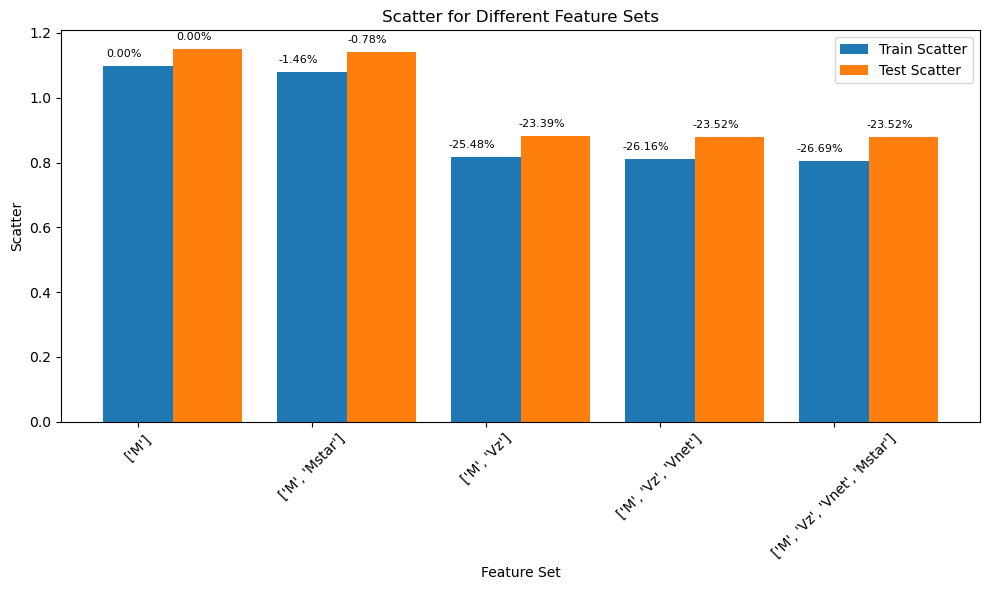

In [90]:

# Fit the model using the best hyperparameters for different feature sets
project.fit_with_hyperparameters(['M'], 'Y')
project.fit_with_hyperparameters(['M', 'Mstar'], 'Y')
project.fit_with_hyperparameters(['M','Vz'], 'Y')
project.fit_with_hyperparameters(['M','Vz', 'Vnet'], 'Y')
project.fit_with_hyperparameters(['M','Vz', 'Vnet','Mstar'], 'Y')

# Calculate and plot the scatter for each feature set
project.plot_scatter_statistics()


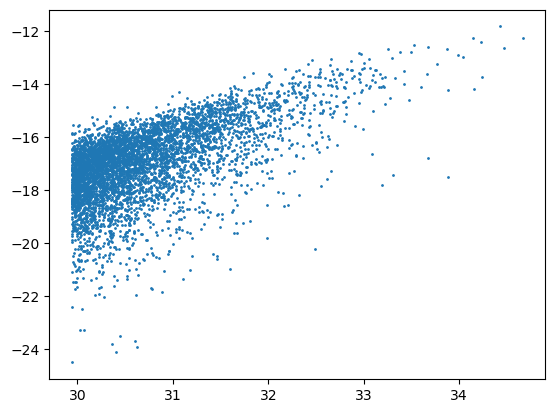

In [39]:
plt.scatter(train_df['M'],train_df['Y'],s=1)

In [84]:
np.corrcoef(train_df['Vnet'],np.abs(train_df['Vlos']))

array([[1.        , 0.43912966],
       [0.43912966, 1.        ]])

In [46]:
def get_inp(features):
    xlen = len(features[0])
    ylen = len(features)
    inp = np.zeros((xlen,ylen))
    for i in range(len(features)):
        inp[:,i] = features[i]
    return inp

In [85]:
inp1 = get_inp([train_df['M']])
inp2 = get_inp([train_df['M'],np.log(train_df['Mstar'])])
inp3 = get_inp([train_df['M'],train_df['Vz']])
inp4 = get_inp([train_df['M'],np.log(train_df['Mstar']),train_df['Vz']])
inp5 = get_inp([train_df['M'],np.log(train_df['Mstar']),train_df['Vz'],train_df['Vnet']])

In [48]:
Y = train_df['Y']

In [40]:
from sklearn.model_selection import GridSearchCV

In [60]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_leaf_nodes': [None, 20, 30,100],  # None means unlimited leaf nodes
}

In [61]:
rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

In [68]:
grid_search.fit(inp4, Y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_leaf_nodes': [None, 20, 30, 100],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [69]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_leaf_nodes': 30, 'n_estimators': 100}


In [70]:
regr1 = RandomForestRegressor(max_depth=50,max_leaf_nodes=30, random_state=0,n_estimators=200,n_jobs=-1)
regr1.fit(inp1, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [71]:
regr2 = RandomForestRegressor(max_depth=50,max_leaf_nodes=30, random_state=0,n_estimators=200,n_jobs=-1)
regr2.fit(inp2, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [72]:
regr3 = RandomForestRegressor(max_depth=50,max_leaf_nodes=30,random_state=0,n_estimators=200,n_jobs=-1)
regr3.fit(inp3, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [73]:
regr4 = RandomForestRegressor(max_depth=50,random_state=0,max_leaf_nodes=30,n_estimators=200,n_jobs=-1)
regr4.fit(inp4, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [86]:
regr5 = RandomForestRegressor(max_depth=50,random_state=0,max_leaf_nodes=30,n_estimators=200,n_jobs=-1)
regr5.fit(inp5, Y)

RandomForestRegressor(max_depth=50, max_leaf_nodes=30, n_estimators=200,
                      n_jobs=-1, random_state=0)

In [87]:
regr5.feature_importances_

array([0.52476442, 0.01434387, 0.45228364, 0.00860806])

In [74]:
def get_pred(inp,regr):
    pred = regr.predict(inp)
    return pred

pred1 = get_pred(inp1,regr1)
pred2 = get_pred(inp2,regr2)
pred3 = get_pred(inp3,regr3)
pred4 = get_pred(inp4,regr4)

Text(0, 0.5, '$\\frac{Y_{predicted}}{Y} -1$')

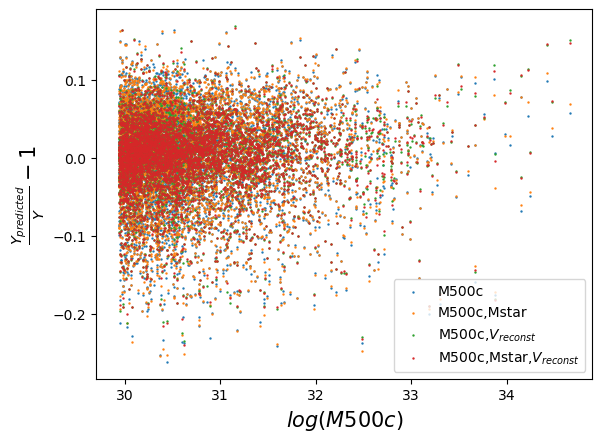

In [78]:
plt.scatter(train_df['M'],pred1/Y - 1,s=0.5,label='M500c')
plt.scatter(train_df['M'],pred2/Y - 1,s=0.5,label='M500c,Mstar')
plt.scatter(train_df['M'],pred3/Y - 1,s=0.5,label='M500c,$V_{reconst}$')
plt.scatter(train_df['M'],pred4/Y - 1,s=0.5,label='M500c,Mstar,$V_{reconst}$')
plt.legend()
plt.xlabel("$log(M500c)$",fontsize=15)
plt.ylabel("$\\frac{Y_{predicted}}{Y} -1$",fontsize=15)

In [76]:
std1 = np.std(pred1/Y - 1)
std2 = np.std(pred2/Y - 1)
std3 = np.std(pred3/Y - 1)
std4 = np.std(pred4/Y - 1)

In [77]:
print((1-std2/std1) *100)
print((1-std3/std1) *100)
print((1-std4/std1) *100)

0.42637415737655227
25.18900647858007
25.269412320245177


In [59]:
Y_M = train_df.Y/train_df.M


In [43]:
inp_sym1 = get_inp([train_df.Vnet])

In [44]:
model = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model.fit(inp_sym1,Y_M,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.810e+03
Head worker occupation: 22.1%. This is high, and will prevent efficient resource usage. Increase `ncyclesperiteration` to reduce load on head worker.
Progress: 11 / 300 total iterations (3.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.906e-03  2.724e-06  -0.55066514
7           2.697e-03  1.247e-02  ((-0.81403726 / sqrt(log(x0))) - 0.22341208)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 6.830e+03
Head worker occupation: 6.1%
Progress: 41 / 300 total iterations (13.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.906e-03  4.086e-06  -0.5506891
5           2.842e-03  5.626e-03  (-0.54492456 + (-1.9172285 / x0))
7           2.694e-03  2.662e-02  (((-0.5811386 / x0) - -5.3600612e-5) * x0)
8           2.691e-03  1.195e-03  ((-0.482071 / sqrt(sqrt(sqrt(x0)))) + -0.3287128)
9           2

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         -0.5506891   
	1  >>>>  0.018934                 ((x0 * 5.3598345e-5) + -0.5811373)   
	2        0.004043          ((sqrt(x0) * 0.0026477987) + -0.61202174)   
	3        0.000002  ((sqrt(x0 + -0.37990904) * 0.0026477987) + -0....   
	
	       loss  complexity  
	0  0.002906           1  
	1  0.002694           5  
	2  0.002683           6  
	3  0.002683           8  
]

In [21]:
Y_primes = Y/model.predict(inp1)

In [22]:
model1 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model1.fit(inp2,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.610e+04
Head worker occupation: 0.6%
Progress: 46 / 300 total iterations (15.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.685e-03  2.772e-06  (x0 ^ -0.00016294773)
4           4.641e-03  9.445e-03  sqrt(27.341019 / x0)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.450e+04
Head worker occupation: 0.6%
Progress: 86 / 300 total iterations (28.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.685e-03  4.232e-06  (x0 ^ -0.00015389819)
4           4.641e-03  9.443e-03  sqrt(27.341019 / x0)
5           4.628e-03  2.782e-03  sqrt(sqrt(27.341019 / x0))
6           4.624e-03  7.341e-04  (sqrt(27.341019 / x0) ^ 0.6662553)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.440e+04
Head work

PySRRegressor.equations_ = [
	   pick     score                            equation      loss  complexity
	0        0.000000                           0.9996168  0.004685           1
	1        0.000018                   (0.99997747 ^ x0)  0.004684           3
	2  >>>>  0.009415                 sqrt(27.34101 / x0)  0.004641           4
	3        0.002781          sqrt(sqrt(27.341022 / x0))  0.004628           5
	4        0.000737  sqrt((27.341019 / x0) ^ 0.6558157)  0.004624           6
]

In [23]:
model2 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model2.fit(inp3,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.520e+04
Head worker occupation: 0.7%
Progress: 42 / 300 total iterations (14.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
4           4.515e-03  1.231e-02  exp(4.7128873 / x0)
5           4.380e-03  3.027e-02  exp(0.7816449 ^ sqrt(x0))
7           4.371e-03  1.083e-03  sqrt(sqrt(sqrt(exp(0.99274904 ^ x0))))
8           4.202e-03  3.930e-02  sqrt(sqrt(exp(0.99274904 ^ x0) / 1.0528436))
9           3.956e-03  6.043e-02  ((x0 + -10344.042) / ((x0 - x0) + -9772.659))

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.700e+04
Head worker occupation: 0.9%
Progress: 94 / 300 total iterations (31.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
4           4.515e-03  1.231e-02  exp(4.7129273 / x0)
5           4.380e-03  3.027e-02  exp(0.7816

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.9996168   
	1        0.000700                               (x0 ^ -0.0004912264)   
	2        0.035526                                 exp(4.712951 / x0)   
	3  >>>>  0.134819                    (-10129.191 / (-9562.382 - x0))   
	4        0.000132      ((-10344.042 / (-9772.659 - x0)) ^ 1.0729246)   
	5        0.000064  (-10344.042 / ((-9772.659 - x0) - (-9772.659 /...   
	6        0.000028  ((-10344.042 / ((-9772.659 - log(x0)) - x0)) ^...   
	
	       loss  complexity  
	0  0.004685           1  
	1  0.004678           3  
	2  0.004515           4  
	3  0.003945           5  
	4  0.003944           7  
	5  0.003944           9  
	6  0.003944          10  
]

In [24]:
model3 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model3.fit(inp4,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 1.900e+04
Head worker occupation: 1.9%
Progress: 54 / 300 total iterations (18.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1.392e-06  0.9996168
3           4.680e-03  4.486e-04  (x1 ^ -0.00016485435)
4           4.515e-03  3.603e-02  exp(4.7129374 / x1)
5           4.422e-03  2.088e-02  exp(0.76063544 ^ sqrt(x1))
7           4.366e-03  6.347e-03  (exp(sqrt(x0) / x1) - 0.012375008)
8           4.322e-03  1.002e-02  exp(log(x0 / sqrt(x1)) / x0)
9           4.259e-03  1.467e-02  (exp(sqrt(x0) / (x1 ^ 0.9134177)) - 0.017082633)
10          4.235e-03  5.714e-03  exp(log((x0 / sqrt(x1)) - 0.14483538) / x0)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 1.570e+04
Head worker occupation: 1.5%
Progress: 90 / 300 total iterations (30.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.685e-03  1

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.9996168   
	1        0.014642                                    (0.999984 ^ x1)   
	2        0.007641                                exp(4.7129374 / x1)   
	3        0.048509                   ((0.9999681 ^ x1) + 0.017361585)   
	4        0.005534                   (((x0 * x0) / x1) ^ 0.037889045)   
	5        0.002891                (sqrt((x0 * x0) / x1) ^ 0.06855952)   
	6  >>>>  0.057986  (((x1 / 1.2694203) ^ (x1 ^ -0.69441396)) - 0.0...   
	
	       loss  complexity  
	0  0.004685           1  
	1  0.004549           3  
	2  0.004515           4  
	3  0.004301           5  
	4  0.004254           7  
	5  0.004241           8  
	6  0.004002           9  
]

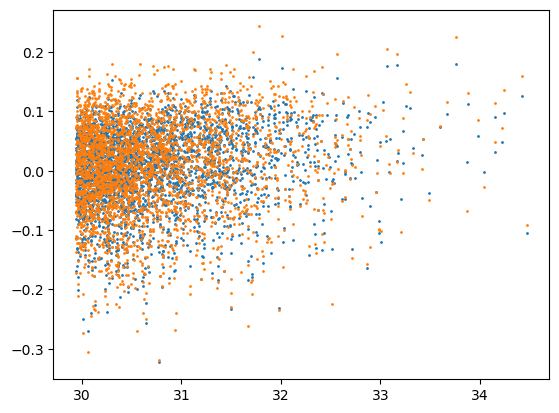

In [30]:
plt.scatter(train_df['M'],model.predict(inp1)/Y -1,s=1,label='PySR[M]')
#plt.scatter(train_df['M'],(model.predict(inp1)/model1.predict(inp2))/Y -1,s=1,label='PySR[M,M*]')
#plt.scatter(train_df['M'],(model.predict(inp1)/model2.predict(inp3))/Y -1,s=1,label='PySR[M,M*]')
plt.scatter(train_df['M'],(model.predict(inp1)/model3.predict(inp4))/Y -1,s=1,label='PySR[M,M*]')
#plt.scatter(train_df['M'],train_df['M']*1.2*model3.predict(inp_3)/Y -1,s=1,label='PySR[M,M*,d_ng]')